# Install AI2-THOR

ProcTHOR houses are loaded into `ai2thor` and distributed with the `prior` package. We'll also install a helper package, called `ai2thor_colab`, which allows us to run AI2-THOR in Google Colab.

Let's install each of these packages below:

In [27]:
# Importing necessary libraries and dependencies
!pip install --upgrade ai2thor --quiet
!pip install ai2thor-colab prior --upgrade &> /dev/null
!apt-get install xvfb -q
!pip install pyvirtualdisplay -q

Reading package lists...
Building dependency tree...
Reading state information...
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [28]:
import gym
from gym import spaces
import numpy as np
from PIL import Image
import random
from ai2thor.controller import Controller
import time
import matplotlib.pyplot as plt
from math import pi
from pyvirtualdisplay import Display
import prior

# Download ProcTHOR-10k

Now, let's use the `prior` package to easily download the `procthor-10k` dataset:

In [29]:
# Loading a dataset using the 'prior' library
dataset = prior.load_dataset("procthor-10k")
dataset

[AI2-THOR WARNING] There has been an update to ProcTHOR-10K that must be used with AI2-THOR version 5.0+. To use the new version of ProcTHOR-10K, please update AI2-THOR to version 5.0+ by running:
    pip install --upgrade ai2thor
Alternatively, to downgrade to the old version of ProcTHOR-10K, run:
   prior.load_dataset("procthor-10k", revision="ab3cacd0fc17754d4c080a3fd50b18395fae8647")


Loading test: 100%|██████████| 1000/1000 [00:00<00:00, 5744.49it/s]


DatasetDict(
    train=Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
),
    val=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=val
),
    test=Dataset(
    dataset=procthor-dataset,
    size=1000,
    split=test
)
)

ProcTHOR-10k comes with 3 splits, including:
- 10k `"train"` houses
- 1k `"val"` houses
- 1k `"test"` houses

these can be obtained by indexing into the dataset:

In [30]:
dataset["train"]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset(
    dataset=procthor-dataset,
    size=10000,
    split=train
)

Here is an example of how to load a single house's JSON file:

In [31]:
# Selecting a house from the dataset for navigation
house = dataset["train"][0]
type(house), house.keys(), house

(dict,
 dict_keys(['doors', 'metadata', 'objects', 'proceduralParameters', 'rooms', 'walls', 'windows']),
 {'doors': [{'assetId': 'Doorway_6',
    'id': 'door|1|2',
    'openable': False,
    'openness': 0,
    'room0': 'room|2',
    'room1': 'room|2',
    'wall0': 'wall|2|5.99|3.99|5.99|5.99',
    'wall1': 'wall|exterior|5.99|3.99|5.99|5.99',
    'holePolygon': [{'x': 0.4987163812589276, 'y': 0, 'z': 0},
     {'x': 1.5362947256040203, 'y': 2.1068506240844727, 'z': 0}],
    'assetPosition': {'x': 1.016530884310268,
     'y': 1.0534253120422363,
     'z': 0}}],
  'metadata': {'agent': {'horizon': 30,
    'position': {'x': 3.5, 'y': 0.95, 'z': 2.0},
    'rotation': {'x': 0, 'y': 90, 'z': 0},
    'standing': True},
   'roomSpecId': 'kitchen',
   'schema': '1.0.0',
   'warnings': {},
   'agentPoses': {'arm': {'horizon': 30,
     'position': {'x': 3.5, 'y': 0.95, 'z': 2.0},
     'rotation': {'x': 0, 'y': 90, 'z': 0},
     'standing': True},
    'default': {'horizon': 30,
     'position': {'

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import namedtuple

# Define the policy network (π)
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Proximal Policy Optimization (PPO) agent
class PPOAgent:
    def __init__(self, input_dim, output_dim):
        self.policy_net = PolicyNetwork(input_dim, output_dim)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.001)

    def select_action(self, state):
        action_probs = F.softmax(self.policy_net(state), dim=-1)
        action_dist = Categorical(action_probs)
        action = action_dist.sample()
        return action

    def optimize_policy(self, states, actions, returns):
        action_probs = F.softmax(self.policy_net(states), dim=-1)
        action_dist = Categorical(action_probs)
        log_probs = action_dist.log_prob(actions)
        loss = -torch.mean(log_probs * returns)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [33]:
import random
import numpy as np
import heapq
import gym
from gym import spaces
from PIL import Image
import matplotlib.pyplot as plt
import time
from pyvirtualdisplay import Display
from ai2thor.controller import Controller
# Define the Particle class, which represents particles for particle filter localization
class Particle:
    def __init__(self, x, y, theta):
        self.x = x
        self.y = y
        self.theta = theta
        self.weight = 1.0

    def move(self, dx, dy, dtheta):
        self.x += dx
        self.y += dy
        self.theta += dtheta

# Define functions for simulating motion and resampling particles
def sample_motion_model(action):
    if action[0] == 0:
        return random.gauss(0.2, 0.1), 0, random.gauss(-10, 2)
    elif action[0] == 1:
        return random.gauss(0.2, 0.1), 0, random.gauss(10, 2)
    elif action[0] == 2:
        return 0, random.gauss(0.2, 0.1), 0
    else:
        return 0, random.gauss(-0.2, 0.1), 0

def resample(particles):
    weights = np.array([p.weight for p in particles])

    if np.isclose(weights.sum(), 0):
        return particles

    num_particles = len(particles)
    resampled_indices = np.random.choice(num_particles, size=num_particles)
    resampled_particles = [particles[i] for i in resampled_indices]

    for particle in resampled_particles:
        particle.weight = 1.0 / num_particles
    print(resampled_particles)
    return resampled_particles

# Define a function to estimate the pose based on particle weights
def estimate_pose(particles):
    total_weight = sum(p.weight for p in particles)
    x = sum(p.x * p.weight for p in particles) / total_weight
    y = sum(p.y * p.weight for p in particles) / total_weight
    theta = sum(p.theta * p.weight for p in particles) / total_weight
    print("x:",x,"y:","theta:",theta)
    return x, y, theta

# Define the Planner2D class for 2D path planning
class Planner2D:
    def __init__(self, grid_size_xz, grid_width, grid_height):
        self.grid_size_xz = grid_size_xz  # Size of each grid cell in x and z dimensions
        self.grid_width = grid_width
        self.grid_height = grid_height
        self.start = None
        self.goal = None

    def plan_path(self, start, goal):
        self.start = start
        self.goal = goal

        # Convert start and goal positions to grid coordinates
        start_grid = self._position_to_grid(start)
        goal_grid = self._position_to_grid(goal)

        # Perform 2D grid-based path planning, e.g., A* algorithm in 2D
        grid_path = self._plan_2d_grid_path(start_grid, goal_grid)

        # Convert grid path back to real-world coordinates
        path = [self._grid_to_position(grid_pos) for grid_pos in grid_path]
        print("path:",path)
        return path

    def _plan_2d_grid_path(self, start_grid, goal_grid):
        # Define possible movements (up, down, left, right) as changes in X and Z coordinates
        movements = [(1, 0), (-1, 0), (0, 1), (0, -1)]

        # Create a priority queue for open nodes (nodes to be explored)
        open_set = []
        heapq.heappush(open_set, (0, start_grid))  # Tuple: (priority, position)

        # Create dictionaries to store the cost and parent of each node
        cost = {start_grid: 0}
        parent = {start_grid: None}

        while open_set:
            # Get the node with the lowest cost from the priority queue
            current_cost, current_node = heapq.heappop(open_set)

            # If the goal is reached, reconstruct the path and return it
            if current_node == goal_grid:
                path = [current_node]
                while current_node in parent and parent[current_node]:
                    current_node = parent[current_node]
                    path.append(current_node)
                path.reverse()
                return path

            # Explore neighbor nodes
            for dx, dz in movements:
                neighbor = (current_node[0] + dx, current_node[1] + dz)

                # Check if the neighbor is within the grid bounds
                if 0 <= neighbor[0] < self.grid_width and 0 <= neighbor[1] < self.grid_height:
                    # Calculate the cost to reach the neighbor
                    neighbor_cost = cost[current_node] + 1  # Assuming uniform cost for simplicity

                    # If this path to the neighbor is shorter, update cost and parent
                    if neighbor not in cost or neighbor_cost < cost[neighbor]:
                        cost[neighbor] = neighbor_cost
                        priority = neighbor_cost + self._heuristic(neighbor, goal_grid)  # A* heuristic
                        heapq.heappush(open_set, (priority, neighbor))
                        parent[neighbor] = current_node

        # If no path is found, return an empty list
        return []

    # Heuristic function for A* (Manhattan distance)
    def _heuristic(self, node, goal):
        return abs(node[0] - goal[0]) + abs(node[1] - goal[1])


    def _position_to_grid(self, position):
        print("Position:", position)
        print("Grid Size XZ:", self.grid_size_xz)

        # Convert real-world position to 2D grid coordinates
        grid_x = int(position[0] / self.grid_size_xz[0])
        grid_z = int(position[1] / self.grid_size_xz[1])
        return (grid_x, grid_z)

    def _grid_to_position(self, grid_position):
        # Convert 2D grid coordinates to real-world position
        position_x = grid_position[0] * self.grid_size_xz[0]
        position_z = grid_position[1] * self.grid_size_xz[1]
        return (position_x, position_z)

    def generate_virtual_guide(self, planned_path):
        return planned_path

class NavigationEnv(gym.Env):
    def __init__(self, house):
        self.display = Display(visible=0, size=(1400, 900))
        self.display.start()
        self.controller = Controller(scene=house, max_agent_duration=600)

        self.action_space = spaces.Box(low=-1, high=1, shape=(2,))

        self.H = 300
        self.W = 400

        self.observation_space = spaces.Box(low=0, high=1, shape=(16 + 2 + self.H * self.W * 3,))
        # self.observation_space = spaces.Box(low=0, high=255, shape=(16 + 2 + 300*300*3,))

        self.controller.reset()
        event = self.controller.step(action="GetReachablePositions")
        reachable_positions = event.metadata["actionReturn"]

        chosen_position = random.choice(reachable_positions)
        agent_x = chosen_position["x"]
        agent_z = chosen_position["z"]
        self.pose = np.array([agent_x, agent_z])

        chosen_goal = random.choice(reachable_positions)
        goal_x = chosen_goal["x"]
        goal_z = chosen_goal["z"]
        self.goal = np.array([goal_x, goal_z])

        # Provide grid dimensions based on your environment's grid size
        grid_size_xz = (0.01, 0.01)
        grid_width = 2000
        grid_height = 2000

        # Provide start and goal positions in real-world 2D coordinates (X and Z)
        start_2d = (agent_x, goal_z)
        goal_2d = (goal_x,goal_z)

        self.path_idx = 0  # Index to keep track of the current goal in the path
        self.planner_2d = Planner2D(grid_size_xz, grid_width, grid_height)  # Store the planned 2D path

        # Plan a 2D path
        self.path_2d = self.planner_2d.plan_path(start_2d, goal_2d)
        self.num_particles = 100
        self.particles = [Particle(self.pose[0], self.pose[1], 0) for _ in range(self.num_particles)]


    def reset(self):
        self.controller.reset()
        event = self.controller.step(action="GetReachablePositions")
        reachable_positions = event.metadata["actionReturn"]

        chosen_position = random.choice(reachable_positions)
        agent_x = chosen_position["x"]
        agent_z = chosen_position["z"]
        self.pose = np.array([agent_x,agent_z])

        chosen_goal = random.choice(reachable_positions)
        goal_x = chosen_goal["x"]
        goal_z = chosen_goal["z"]
        self.goal = np.array([goal_x,goal_z])

        # Plan a 2D path and store it
        self.path_2d = self.planner_2d.plan_path(self.pose, self.goal)
        self.path_idx = 0  # Reset the path index to start from the beginning

        return self._get_obs()

    def step(self, action):
        if action[0] == 0:
            self.controller.step(action="MoveLeft")
        elif action[0] == 1:
            self.controller.step(action="MoveRight")
        elif action[0] == 2:
            self.controller.step(action="MoveAhead")
        elif action[0] == 3:
            self.controller.step(action="MoveBack")

        event = self.controller.last_event
        self.pose = [event.metadata['agent']['position']['x'],
                     event.metadata['agent']['position']['z']]

        scans = self._get_scans()

        d = np.linalg.norm(self.pose - self.goal)
        if d < 1:
            reward = 1.0
            done = True
        else:
            reward = -0.1
            done = False

        for particle in self.particles:
            dx, dy, dtheta = sample_motion_model(action)
            particle.move(dx, dy, dtheta)

        weights = self.calculate_particle_weights()

        self.particles = resample(self.particles)

        self.pose = estimate_pose(self.particles)

        planned_path = self.planner_2d.plan_path(self.pose, self.goal)

        if planned_path:
            virtual_guide = self.planner_2d.generate_virtual_guide(planned_path)
        else:
            virtual_guide = []
       # Check if the agent has reached the end of the planned path
        if self.path_idx >= len(self.path_2d):
            done = True  # End the episode when the planned path is completed
        else:
            done = False

        if self.path_idx < len(self.path_2d):

            goal_x = self.path_2d[self.path_idx][0]
            goal_z = self.path_2d[self.path_idx][1]

            agent_x = self.pose[0]
            agent_z = self.pose[1]

            dx = goal_x - agent_x
            dz = goal_z - agent_z

            relative_pos = np.array([dx, dz])
            if relative_pos[0] > 0.1:
                action = (3,)  # Move forward
            elif relative_pos[0] < -0.1:
                action = (2,)  # Move back
            elif relative_pos[1] > 0.1:
                action = (1,)  # Move right
            elif relative_pos[1] < -0.1:
                action = (0,)  # Move left

        return self._get_obs(), reward, done, {"planned_path": self.path_2d[self.path_idx:]}

    def _get_obs(self):
        scans = self._get_scans()

        event = self.controller.last_event
        image = event.frame[:, :, :3]

        obs = np.concatenate([scans, self.pose, image.flatten()])
        return obs

    def _get_scans(self):
        return np.random.randn(16)

    def calculate_likelihood(self, expected_sensor_data, actual_sensor_data):
        measurement_noise_stddev = 0.1
        likelihood = 1.0 / (measurement_noise_stddev * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((expected_sensor_data - actual_sensor_data) / measurement_noise_stddev)**2)
        print("likelihood:",likelihood)
        return likelihood

    def calculate_particle_weights(self):
        weights = []
        for particle in self.particles:
            expected_sensor_data = self.simulate_sensor_measurement(particle)
            actual_sensor_data = self.get_actual_sensor_measurement()
            likelihood = self.calculate_likelihood(expected_sensor_data, actual_sensor_data)
            weights.append(likelihood)

        weights = np.array(weights)

        if np.all(np.isclose(weights, 0)):
            num_particles = len(self.particles)
            normalized_weights = np.full(num_particles, 1.0 / num_particles)
        else:
            normalized_weights = weights / weights.sum()

        for i, particle in enumerate(self.particles):
            particle.weight = normalized_weights[i]
        print("calculated particle weights:",normalized_weights)
        return normalized_weights

    def simulate_sensor_measurement(self, particle):
        target_x, target_y = self.goal
        dx = target_x - particle.x
        dy = target_y - particle.y
        distance_to_goal = np.sqrt(dx**2 + dy**2)
        measurement_noise = np.random.normal(0, 0.1)
        simulated_sensor_data = distance_to_goal + measurement_noise
        return simulated_sensor_data

    def get_actual_sensor_measurement(self):
        actual_sensor_data = np.random.randn(16)
        return actual_sensor_data

#house = dataset["train"][0]
env = NavigationEnv("FloorPlan221")

Position: (-2.0, -1.75)
Grid Size XZ: (0.01, 0.01)
Position: (-1.0, -1.75)
Grid Size XZ: (0.01, 0.01)
path: []


[-2.   -0.25]
[-1.   -1.75]
likelihood: [9.44168404e-095 2.44562654e-219 5.91589534e-022 1.95170542e-022
 1.26776309e-137 1.52159280e-002 2.70215762e-007 7.60334211e-049
 3.77670418e-007 3.00313172e-025 2.72937926e-077 1.06543103e-123
 1.14812511e-197 4.59709087e-050 3.29049224e-141 2.32337179e-104]
likelihood: [1.57953852e-050 6.01041447e-212 9.18247463e-046 3.22872072e+000
 3.00136866e-010 3.05189681e-097 2.03579861e-127 1.01282576e-048
 3.52115390e+000 1.18482891e-020 1.66086908e-022 2.83820410e-085
 2.38608980e-001 2.00482570e-016 1.99235398e-070 6.65977537e-234]
likelihood: [6.76943826e-020 2.16642173e-163 9.91579914e-104 5.71098468e-143
 4.49544375e-004 3.46989510e+000 2.68667057e-083 3.35667812e-017
 8.63105430e-020 1.43866750e+000 1.86263294e-032 7.63624634e-091
 1.71401649e-034 3.76423861e-001 2.57736398e-011 1.14485951e-072]
likelihood: [1.23132101e-034 1.76272372e-099 3.67047697e-065 1.72795939e-084
 1.92153633e-066 6.79891300e-055 3.94361226e-051 1.64948780e-102
 1.02953938

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 640x480 with 0 Axes>

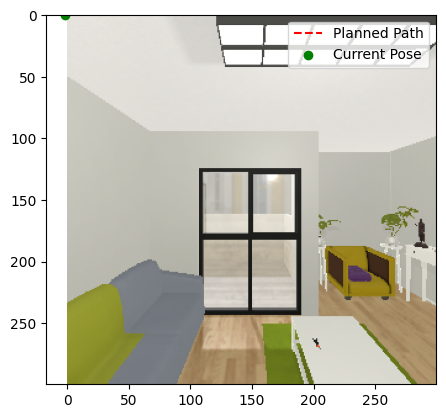

In [34]:

done = False
while not done:
    print(env.pose)
    print( env.goal)
    # Calculate Euclidean distance to goal
    euclidean_distance = np.linalg.norm(env.pose[:2] - env.goal)

    # Use proportional action based on the vector to the goal (for smoother movement)
    if euclidean_distance > 0.001:
        relative_position = env.goal - env.pose[:2]
        action = np.array([relative_position[1], relative_position[0]])
        action /= np.linalg.norm(action)  # Normalize the action vector
        action = np.clip(action, -1, 1)  # Clip the action to the range [-1, 1]

    # Step in the environment to get new observation and other information
    obs, reward, done, info = env.step(action)

    # Visualize the planned path and current pose
    plt.figure(1)
    img_obs = obs[-270000:]
    frame = img_obs.reshape(300, 300, 3)
    frame = frame.astype(np.uint8)
    img = Image.fromarray(frame)
    plt.figure(2)
    plt.imshow(img)
    plt.plot([p[0] for p in env.path_2d], [p[1] for p in env.path_2d], 'r--', label='Planned Path')
    plt.scatter(env.pose[0], env.pose[1], c='g', marker='o', label='Current Pose')
    plt.legend()
    plt.show()

In [35]:
# Training loop
state_dim = env.observation_space.shape[0]
action_dim = 2  # Assuming 2 continuous actions (linear and angular velocities)

agent = PPOAgent(state_dim, action_dim)
num_episodes = 1000

for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_data = []

    while not done:
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action.item())
        episode_data.append((state, action, reward))
        state = next_state

    # Calculate returns (e.g., using discounted rewards)
    returns = calculate_returns(episode_data)

    # Optimize the policy (π) using PPO
    states, actions, _ = zip(*episode_data)
    states = torch.cat(states)
    actions = torch.tensor(actions, dtype=torch.int64).view(-1, 1)
    agent.optimize_policy(states, actions, returns)

print("Training complete.")

# Deployment of the trained policy
state = env.reset()
done = False

while not done:
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action = agent.select_action(state)
    next_state, _, done, _ = env.step(action.item())
    state = next_state


Position: [-0.25 -1.25]
Grid Size XZ: (0.01, 0.01)
Position: [-3.25 -2.5 ]
Grid Size XZ: (0.01, 0.01)
path: []


RuntimeError: ignored